In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from random import randint
import scipy

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, AvgPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19

2024-04-07 17:45:14.240188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 17:45:14.240284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 17:45:14.395128: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define data directories
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [3]:
# Data exploration
train_class_counts = {}
for class_name in os.listdir(train_dir):
    train_class_counts[class_name] = len(os.listdir(os.path.join(train_dir, class_name)))
print("Training Class Counts:", train_class_counts)


Training Class Counts: {'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}


In [4]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation/test data

In [6]:
batch_size = 32
image_size = (150, 150)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')  # Use 'sparse' for integer labels

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [8]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [9]:
idx_to_classes = {val:key for key, val in dict(train_generator.class_indices).items()}
idx_to_classes

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [10]:
# Load the pre-trained VGG19 model without including the top fully-connected layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model by adding layers on top of the convolutional base
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,  # Adjust number of epochs as needed
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/438 ━━━━━━━━━━━━━━━━━━━━ 35s 80ms/step - accuracy: 0.1328 - loss: 2.6358   

I0000 00:00:1712511964.196856     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712511964.219010     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


396/438 ━━━━━━━━━━━━━━━━━━━━ 16s 391ms/step - accuracy: 0.6721 - loss: 0.9679

W0000 00:00:1712512118.455056     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - accuracy: 0.6781 - loss: 0.9441

W0000 00:00:1712512133.426779     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 206s 423ms/step - accuracy: 0.6783 - loss: 0.9436 - val_accuracy: 0.8290 - val_loss: 0.4811
Epoch 2/20
  1/438 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.7500 - loss: 0.5371

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


438/438 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7500 - loss: 0.5371 - val_accuracy: 0.7917 - val_loss: 0.2981
Epoch 3/20


W0000 00:00:1712512163.246902     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 113s 253ms/step - accuracy: 0.7901 - loss: 0.5644 - val_accuracy: 0.8552 - val_loss: 0.3999
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 198us/step - accuracy: 0.8125 - loss: 0.6423 - val_accuracy: 0.9167 - val_loss: 0.2403
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 114s 256ms/step - accuracy: 0.8060 - loss: 0.5185 - val_accuracy: 0.8414 - val_loss: 0.4175
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 200us/step - accuracy: 0.6562 - loss: 0.6307 - val_accuracy: 0.9583 - val_loss: 0.1764
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 112s 252ms/step - accuracy: 0.8212 - loss: 0.4736 - val_accuracy: 0.8626 - val_loss: 0.3683
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 206us/step - accuracy: 0.8125 - loss: 0.3668 - val_accuracy: 0.7500 - val_loss: 0.4485
Epoch 9/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 112s 252ms/step - accuracy: 0.8107 - loss: 0.4957 - val_accuracy: 0.8629 - val_loss: 0.3746
Epoch 10/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 191us/step - accuracy: 0.8750 - loss: 0.2988 - va

In [13]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

94/94 - 9s - 91ms/step - accuracy: 0.8590 - loss: 0.3850

Test accuracy: 0.859000027179718


# Model Metrics

In [14]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
test_loss = history.history["val_loss"]
test_accuracy = history.history["val_accuracy"]

### Train Loss vs Validation Loss

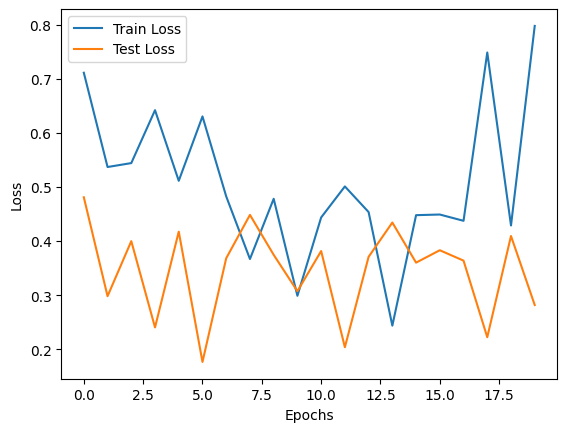

In [15]:
plt.plot(range(20), train_loss, label = "Train Loss")
plt.plot(range(20), test_loss, label = "Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## Train Accuracy vs Validation Accuracy

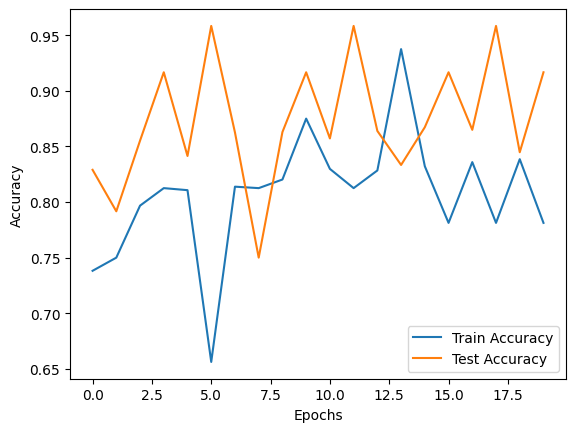

In [16]:
plt.plot(range(20), train_accuracy, label = "Train Accuracy")
plt.plot(range(20), test_accuracy, label = "Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [17]:
pred_list = [rf"/kaggle/input/intel-image-classification/seg_pred/seg_pred/{i}" for i in os.listdir(r"/kaggle/input/intel-image-classification/seg_pred/seg_pred")]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


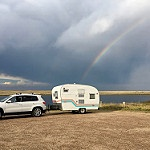

Model Prediction: sea
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


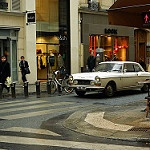

Model Prediction: street
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


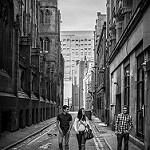

Model Prediction: street
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


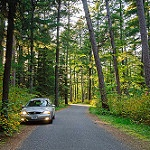

Model Prediction: forest
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


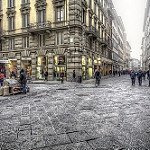

Model Prediction: buildings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


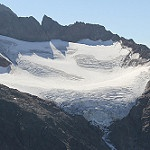

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


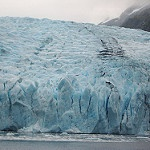

Model Prediction: glacier
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


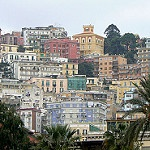

Model Prediction: buildings
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


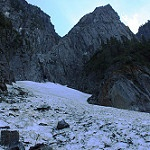

Model Prediction: mountain
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


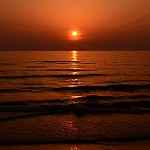

Model Prediction: sea


In [18]:
from random import randint
from PIL import Image

# Function to preprocess and predict images
def preprocess_and_predict(image_path, model):
    img = Image.open(image_path)
    img = img.resize((150, 150))  # Resize image to match model input shape
    img_arr = np.array(img)  # Convert image to numpy array
    img_arr = img_arr / 255.0  # Normalize pixel values
    img_arr = img_arr[np.newaxis, :]  # Add batch dimension
    probability = model.predict(img_arr)  # Predict probabilities
    pred = np.argmax(probability)  # Get predicted class index
    return idx_to_classes[pred]  # Return predicted class label

# Generate random images and make predictions
for i in range(10):
    num = randint(0, len(pred_list))
    image_path = pred_list[num]
    predicted_class = preprocess_and_predict(image_path, model)
    
    # Display the image and predicted class
    img = Image.open(image_path)
    display(img)
    print("Model Prediction:", predicted_class)
    print("==========================================")
